# Выполнил:
# Радайкин Артём, ПМ20-4 

## Загружаем данные

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import patsy as pt
import sklearn.linear_model as lm
import scipy.stats as sts
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
pd.set_option('display.max_columns' , None)
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
import xgboost
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Эконометрика /ДТЗ/ds_salaries.csv')
df.drop(['Unnamed: 0', 'salary_currency'], axis=1, inplace=True)
df.head(5)

,work_year,experience_level,employment_type,job_title,salary,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,150000,US,50,US,L


### Описание данных:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_in_usd       607 non-null    int64 
 6   employee_residence  607 non-null    object
 7   remote_ratio        607 non-null    int64 
 8   company_location    607 non-null    object
 9   company_size        607 non-null    object
dtypes: int64(4), object(6)
memory usage: 47.5+ KB


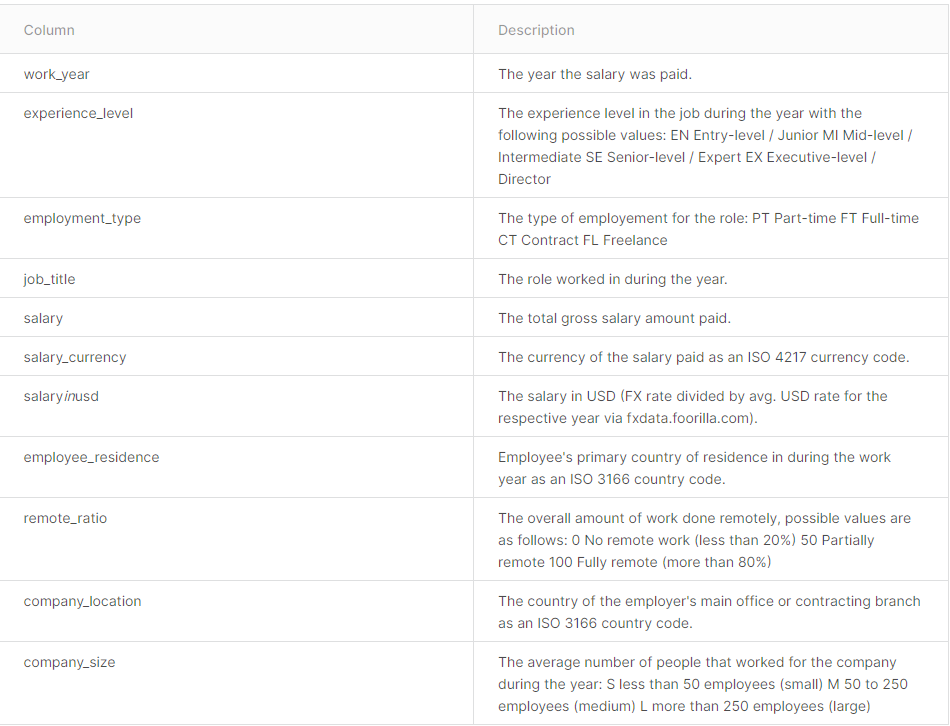

In [ ]:
experience = {
    "EN":0,
    "MI":1,
    "SE":2,
    "EX":3
}


In [ ]:
df['experience_level'] = df['experience_level'].map(experience)

In [ ]:
def Titles_reduction(x):
    if ( x.find("Data Science")>=0  or  x.find("Data Scientist")>=0   ):
        df['job_title'].replace(x,'Data Scientist',inplace = True)
    elif ( x.find("Analyst")>=0  or  x.find("Analytics")>=0 ): 
        df['job_title'].replace(x,'Data Analyst',inplace = True)
    elif ( x.find("ML")>=0  or  x.find("Machine Learning")>=0 ) :
        df['job_title'].replace(x,'Machine Learning Engineer',inplace = True) 
    elif ( x.find("Data Engineer")>=0  or  x.find("Data Engineering")>=0 ):
        df['job_title'].replace(x,'Data Engineer',inplace = True)
    else : 
        df['job_title'].replace(x,'AI related',inplace = True)

In [ ]:
for i in df['job_title']:
    Titles_reduction(i)

In [ ]:
df['job_title'].value_counts()

Data Scientist               192
Data Engineer                158
Data Analyst                 135
Machine Learning Engineer     68
AI related                    54
Name: job_title, dtype: int64

In [ ]:
size = {
    "S":0,
    "M":1,
    "L":2
}

In [ ]:
df['company_size'] = df['company_size'].map(size)

In [ ]:
def res(x):
    if (x == "US"):
        return "US" 
    else :
        return "Other"

In [ ]:
df['employee_residence'] = df['employee_residence'].apply(res)
df['company_location'] = df['company_location'].apply(res)

In [ ]:
# Прологарифмируем зарплату в USD 
df['salary_in_usd'] = np.log(df['salary_in_usd']) 
df['salary_in_usd']

0      11.287692
1      12.468437
2      11.599323
3       9.903488
4      11.918391
         ...    
602    11.944708
603    11.744037
604    11.767568
605    11.918391
606    12.206073
Name: salary_in_usd, Length: 607, dtype: float64

In [ ]:
nums = df.select_dtypes(exclude="object").columns
nums

Index(['work_year', 'experience_level', 'salary', 'salary_in_usd',
       'remote_ratio', 'company_size'],
      dtype='object')

In [ ]:
cats = df.select_dtypes(include="object").columns
cats

Index(['employment_type', 'job_title', 'employee_residence',
       'company_location'],
      dtype='object')

In [ ]:
df = df[(df.salary_in_usd < 500_000)]

In [ ]:
df['job_title'] = df.job_title.map(lambda x: x.replace(' ','_'))

### Распределение зарплаты 


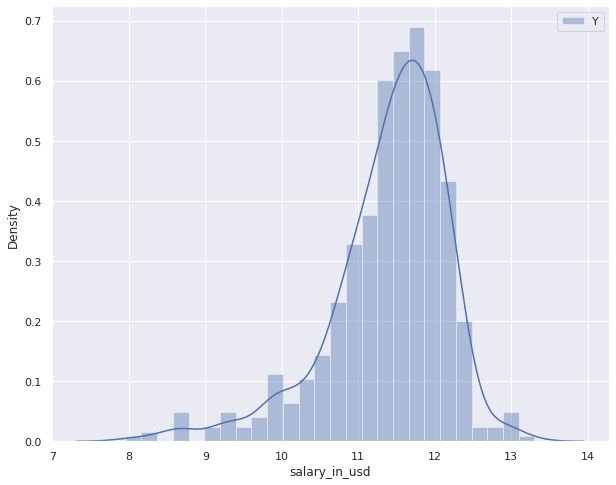

In [ ]:
# Распределение зарплаты
sns.set()
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(df['salary_in_usd'], ax=ax, label='Y').legend();
# px.histogram(df, x = 'salary_in_usd' , template = 'ggplot2' , labels = {'salary_in_usd' : 'salary'} , title = '<b> Распределение зарплаты в USD')

In [ ]:
# Выделяем X и Y для дальнейших моделей
X, Y = df.drop(["salary_in_usd", "salary"], axis=1) , df["salary_in_usd"] 

# **Машинное обучение с помощью CatBoostRegressor**



### **Разделяем данные с помощью train_test_split**

In [ ]:
# Выделяем X и Y для дальнейших моделей
X, Y = df.drop(["salary_in_usd", "salary"], axis=1) , df["salary_in_usd"] 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=32)

# В качестве признаков выбираем все данные, которые не float 
cat_features = np.where(X.dtypes != np.float)[0]

### **Запускаем градиентный бустинг** 

In [ ]:
model = CatBoostRegressor (
        iterations=200,
        learning_rate=0.05,
        loss_function='RMSE',
        random_seed=32, 
        depth=7 
)

model.fit(X, Y,
        cat_features=cat_features,
        eval_set=(X_test, y_test),
        verbose=25,
        plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7564951	test: 0.7361185	best: 0.7361185 (0)	total: 2.97ms	remaining: 591ms
25:	learn: 0.5585152	test: 0.5292910	best: 0.5292910 (25)	total: 62.2ms	remaining: 416ms
50:	learn: 0.5013679	test: 0.4790580	best: 0.4790580 (50)	total: 120ms	remaining: 351ms
75:	learn: 0.4768245	test: 0.4627914	best: 0.4627914 (75)	total: 177ms	remaining: 288ms
100:	learn: 0.4595264	test: 0.4543351	best: 0.4543351 (100)	total: 236ms	remaining: 231ms
125:	learn: 0.4400370	test: 0.4469259	best: 0.4469259 (125)	total: 298ms	remaining: 175ms
150:	learn: 0.4270476	test: 0.4399297	best: 0.4396496 (144)	total: 359ms	remaining: 116ms
175:	learn: 0.4174184	test: 0.4366190	best: 0.4366190 (175)	total: 419ms	remaining: 57.1ms
199:	learn: 0.4094916	test: 0.4330470	best: 0.4330470 (199)	total: 484ms	remaining: 0us

bestTest = 0.4330470068
bestIteration = 199



In [ ]:
model.predict(X)

In [ ]:
model.best_score_

{'learn': {'RMSE': 0.4094916433364214},
 'validation': {'RMSE': 0.43304700679710856}}

### **Различные метрики:**

In [ ]:
print(f'The R-squared value : {r2_score(Y, model.predict(X))}')
print(f'RMSE : {np.sqrt(mean_squared_error(Y, model.predict(X)))}')
print(f'MAE : {mean_absolute_error(Y, model.predict(X))}')
print(f'RMSLE : {np.sqrt(mean_squared_log_error(Y, model.predict(X)))}')
print(f'MAPE : {mean_absolute_percentage_error(Y, model.predict(X))}')

The R-squared value : 0.6480043928955711
RMSE : 0.4589159939769242
MAE : 0.3290423058039776
RMSLE : 0.03945569603276474
MAPE : 0.030062273191435465


In [ ]:
# Точность для тренировочных данных 

# print(f'The R-squared value : {r2_score(y_train, model.predict(X_train))}')
# print(f'RMSE : {np.sqrt(mean_squared_error(y_train, model.predict(X_train)))}')
# print(f'MAE : {mean_absolute_error(y_train, model.predict(X_train))}')
# print(f'RMSLE : {np.sqrt(mean_squared_log_error(y_train, model.predict(X_train)))}')
# print(f'MAPE : {mean_absolute_percentage_error(y_train, model.predict(X_train))}')

The R-squared value : 0.6389213125276163
RMSE : 0.46964114336853807
MAE : 0.33624423664071185
RMSLE : 0.040379980113958186
MAPE : 0.030680526224414844


In [ ]:
# # Точность для тестируемых данных

# print(f'The R-squared value: {r2_score(y_test, model.predict(X_test))}') 
# print(f'RMSE : {np.sqrt(mean_squared_error(y_test, model.predict(X_test)))}')
# print(f'MAE : {mean_absolute_error(y_test, model.predict(X_test))}')
# print(f'RMSLE : {np.sqrt(mean_squared_log_error(y_test, model.predict(X_test)))}')
# print(f'MAPE : {mean_absolute_percentage_error(y_test, model.predict(X_test))}')

The R-squared value: 0.6702583106855562
RMSE : 0.4330469770988237
MAE : 0.3123558649582105
RMSLE : 0.037226106404885266
MAPE : 0.02862981807677287


### **Оценка влияния признаков**

In [ ]:
features_value = model.get_feature_importance()
features_name = X.columns.values

print('Значения признаков: ')
for i in range(len(features_name)):
  print(f'{features_name[i]}: {np.round(features_value[i], 3)}')

Значения признаков: 
work_year: 11.259
experience_level: 21.699
employment_type: 3.687
job_title: 11.626
employee_residence: 34.546
remote_ratio: 5.073
company_location: 3.16
company_size: 8.95


# **Таблица сравнения итоговых результатов**

In [ ]:
comparison = pd.DataFrame({'Real_Item_Outlet_Sales': y_test,'Model_Item_Outlet_Sales': model.predict(X_test), 'Differences (%)': abs(((y_test-model.predict(X_test))/y_test)*100)})
comparison

,Real_Item_Outlet_Sales,Model_Item_Outlet_Sales,Differences (%)
51,11.418615,11.341751,0.673147
19,10.933107,10.747620,1.696567
438,12.152936,11.830159,2.655951
238,8.294050,10.289678,24.060970
188,11.249390,11.418174,1.500385
...,...,...,...
242,11.608236,11.795875,1.616430
70,11.046531,10.664149,3.461559
558,12.232228,11.820643,3.364754
182,10.166044,10.835041,6.580698


In [ ]:
df['Y_hat'] = model.predict(X)

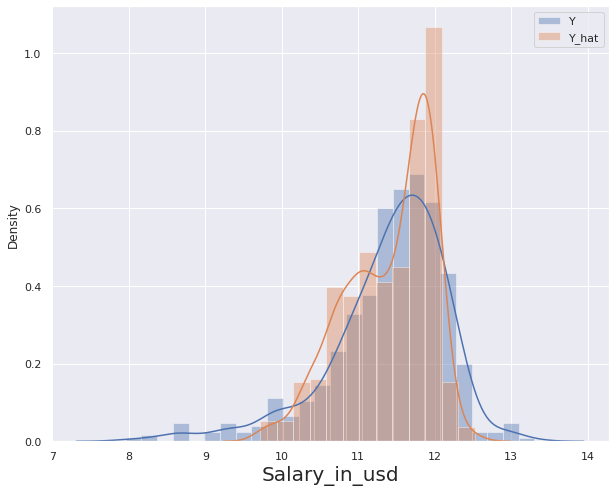

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(df['salary_in_usd'], ax=ax, label='Y').legend()
sns.distplot(df['Y_hat'], ax=ax, label='Y_hat').legend()
ax.set_xlabel('Salary_in_usd', size=20);

# **XGBoost**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   work_year           607 non-null    int64  
 1   experience_level    607 non-null    int64  
 2   employment_type     607 non-null    object 
 3   job_title           607 non-null    object 
 4   salary              607 non-null    int64  
 5   salary_in_usd       607 non-null    float64
 6   employee_residence  607 non-null    object 
 7   remote_ratio        607 non-null    int64  
 8   company_location    607 non-null    object 
 9   company_size        607 non-null    int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 52.2+ KB


### **Разделяем данные с помощью train_test_split**

In [ ]:
df1 = pd.get_dummies(df,columns=cats,drop_first=True)

In [ ]:
# define dataset
X, Y = df1.drop(["salary_in_usd", "salary"], axis=1) , df1["salary_in_usd"] 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, random_state=42)

### **Машинное обучение**

In [ ]:
model = xgboost.XGBRegressor().fit(X, Y)

[11:20:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
model.predict(X)

### **Различные метрики:**

In [ ]:
print(f'The R-squared value : {r2_score(Y, model.predict(X))}')
print(f'RMSE : {np.sqrt(mean_squared_error(Y, model.predict(X)))}')
print(f'MAE : {mean_absolute_error(Y, model.predict(X))}')
print(f'RMSLE : {np.sqrt(mean_squared_log_error(Y, model.predict(X)))}')
print(f'MAPE : {mean_absolute_percentage_error(Y, model.predict(X))}')

The R-squared value : 0.776626088695758
RMSE : 0.36557862619759435
MAE : 0.27078228622881634
RMSLE : 0.03078109980375362
MAPE : 0.024412673019746138


In [ ]:
# # Точность для тренировочных данных 

# print(f'The R-squared value : {r2_score(y_train, model.predict(X_train))}')
# print(f'RMSE : {np.sqrt(mean_squared_error(y_train, model.predict(X_train)))}')
# print(f'MAE : {mean_absolute_error(y_train, model.predict(X_train))}')
# print(f'RMSLE : {np.sqrt(mean_squared_log_error(y_train, model.predict(X_train)))}')
# print(f'MAPE : {mean_absolute_percentage_error(y_train, model.predict(X_train))}')

In [ ]:
# # Точность для тестируемых данных

# print(f'The R-squared value: {r2_score(y_test, model.predict(X_test))}') 
# print(f'RMSE : {np.sqrt(mean_squared_error(y_test, model.predict(X_test)))}')
# print(f'MAE : {mean_absolute_error(y_test, model.predict(X_test))}')
# print(f'RMSLE : {np.sqrt(mean_squared_log_error(y_test, model.predict(X_test)))}')
# print(f'MAPE : {mean_absolute_percentage_error(y_test, model.predict(X_test))}')

In [ ]:
df['Y_hat'] = model.predict(X)

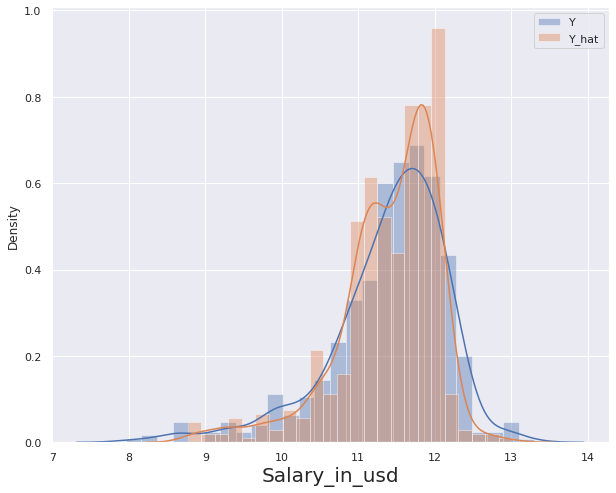

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(df['salary_in_usd'], ax=ax, label='Y').legend()
sns.distplot(df['Y_hat'], ax=ax, label='Y_hat').legend()
ax.set_xlabel('Salary_in_usd', size=20);